In [369]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

In [370]:
df = pd.read_csv('/kaggle/input/nike-shoes-sales/nike_shoes_sales.csv')

In [371]:
df.shape

(643, 10)

In [372]:
df.head(5)

,product_name,product_id,listing_price,sale_price,discount,brand,description,rating,reviews,images
0,Nike Air Force 1 '07 Essential,CJ1646-600,0,7495,0,Nike,Let your shoe game shimmer in the Nike Air For...,0.0,0,"[""https://static.nike.com/a/images/t_PDP_1728_..."
1,Nike Air Force 1 '07,CT4328-101,0,7495,0,Nike,The legend lives on in the Nike Air Force 1 '0...,0.0,0,"[""https://static.nike.com/a/images/t_PDP_1728_..."
2,Nike Air Force 1 Sage Low LX,CI3482-200,0,9995,0,Nike,"Taking both height and craft to new levels, th...",0.0,0,"[""https://static.nike.com/a/images/t_PDP_1728_..."
3,Nike Air Max Dia SE,CD0479-200,0,9995,0,Nike,"Designed for a woman's foot, the Nike Air Max ...",0.0,0,"[""https://static.nike.com/a/images/t_PDP_1728_..."
4,Nike Air Max Verona,CZ6156-101,0,9995,0,Nike,Pass on the good vibes in the Nike Air Max Ver...,0.0,0,"[""https://static.nike.com/a/images/t_PDP_1728_..."


In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_name   643 non-null    object 
 1   product_id     643 non-null    object 
 2   listing_price  643 non-null    int64  
 3   sale_price     643 non-null    int64  
 4   discount       643 non-null    int64  
 5   brand          643 non-null    object 
 6   description    640 non-null    object 
 7   rating         643 non-null    float64
 8   reviews        643 non-null    int64  
 9   images         572 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 50.4+ KB


In [374]:
df.describe()

,listing_price,sale_price,discount,rating,reviews
count,643.000000,643.000000,643.0,643.000000,643.000000
mean,3875.762053,10213.676516,0.0,2.734837,7.181960
std,5889.947172,4513.289512,0.0,2.137756,15.968315
min,0.000000,1595.000000,0.0,0.000000,0.000000
25%,0.000000,6995.000000,0.0,0.000000,0.000000
50%,0.000000,9597.000000,0.0,3.800000,1.000000
75%,8495.000000,12797.000000,0.0,4.600000,6.000000
max,19995.000000,36500.000000,0.0,5.000000,223.000000


In [375]:
#Drop discount column as it is constant and all 0 and also images as we won't be using them
df.drop(['discount', 'images'], axis=1, inplace=True)

In [376]:
df.isnull().sum()

product_name     0
product_id       0
listing_price    0
sale_price       0
brand            0
description      3
rating           0
reviews          0
dtype: int64

In [377]:
# Handle missing values
df['description'].fillna('', inplace=True)

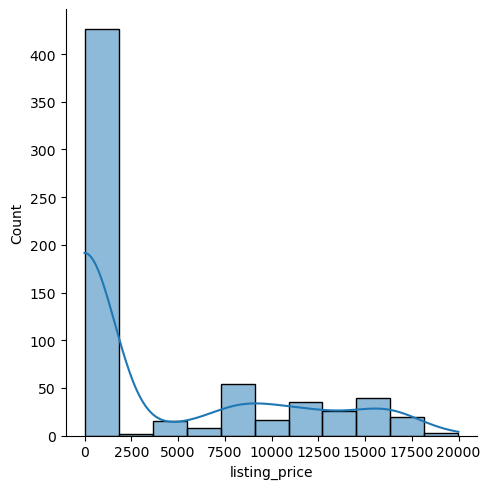

In [378]:
sns.displot(data=df, x="listing_price", kde=True)

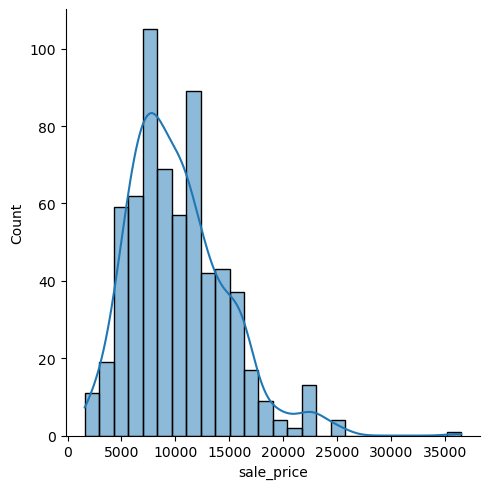

In [379]:
sns.displot(data=df, x="sale_price", kde=True)

In [380]:
#Convert to $ as sales numbers are not reflecting the true values
df['sale_price'] = df['sale_price'] / 100
df['listing_price'] = df['listing_price'] / 100

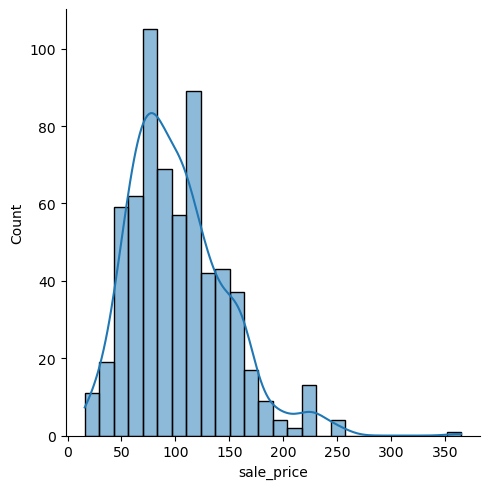

In [381]:
sns.displot(data=df, x="sale_price", kde=True)

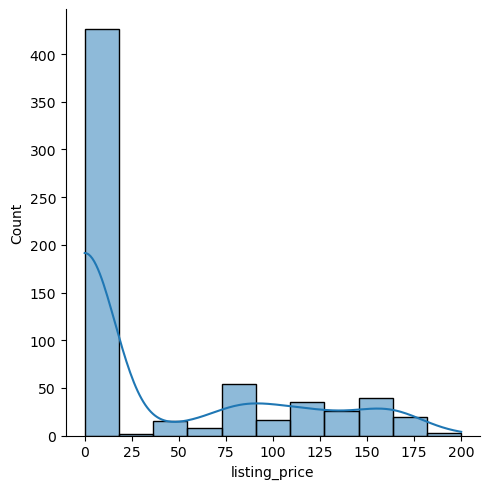

In [382]:
sns.displot(data=df, x="listing_price", kde=True)

In [383]:
# Check for zero values
zero_prices = df[df['listing_price'] == 0]
if not zero_prices.empty:
    print("Found zero values in listing_price!")
    # Handle these zero values accordingly, e.g., replace with a small value, drop them, or replace with the median listing price.
    median_price = df['listing_price'].median()
    df.loc[df['listing_price'] == 0, 'listing_price'] = median_price

Found zero values in listing_price!


In [384]:
'''
For each product with a listing_price of zero, we'll find a similar product based on the product name. 
Then, we'll impute the listing_price of our target product with the sale_price of the most similar product. 
'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Vectorize product names using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['product_name'])

# Function to get the index of the most similar product
def get_similar_product(idx):
    cosine_similarities = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
    # We ignore the product itself by setting its similarity to -1
    cosine_similarities[idx] = -1
    return cosine_similarities.argmax()

# 2. For each product with a listing_price of zero, find the most similar product
zero_price_indices = df[df['listing_price'] == 0].index

for idx in zero_price_indices:
    similar_idx = get_similar_product(idx)
    # Impute with the sale_price of the most similar product
    df.at[idx, 'listing_price'] = df.at[similar_idx, 'sale_price']

In [385]:
df

,product_name,product_id,listing_price,sale_price,brand,description,rating,reviews
0,Nike Air Force 1 '07 Essential,CJ1646-600,55.97,74.95,Nike,Let your shoe game shimmer in the Nike Air For...,0.0,0
1,Nike Air Force 1 '07,CT4328-101,74.95,74.95,Nike,The legend lives on in the Nike Air Force 1 '0...,0.0,0
2,Nike Air Force 1 Sage Low LX,CI3482-200,89.95,99.95,Nike,"Taking both height and craft to new levels, th...",0.0,0
3,Nike Air Max Dia SE,CD0479-200,59.97,99.95,Nike,"Designed for a woman's foot, the Nike Air Max ...",0.0,0
4,Nike Air Max Verona,CZ6156-101,99.95,99.95,Nike,Pass on the good vibes in the Nike Air Max Ver...,0.0,0
...,...,...,...,...,...,...,...,...
638,Air Jordan 8 Retro,CI1236-100,159.95,127.97,Nike,The Air Jordan 8 Retro recaptures the memorabl...,5.0,1
639,Nike Phantom Venom Club IC,AO0578-717,49.95,34.97,Nike,The Nike Phantom Venom Club IC is engineered f...,0.0,0
640,Nike Mercurial Superfly 7 Academy TF,AT7978-414,84.95,59.47,Nike,The soft upper of the Nike Mercurial Superfly ...,5.0,1
641,Nike Air Max 98,AH6799-300,169.95,169.95,Nike,The Nike Air Max 98 features the OG design lin...,4.0,4


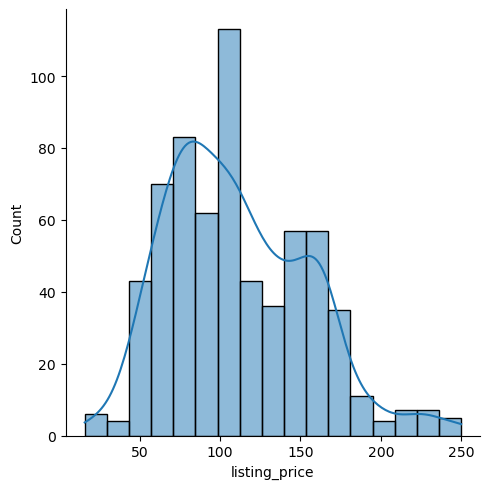

In [386]:
sns.displot(data=df, x="listing_price", kde=True)

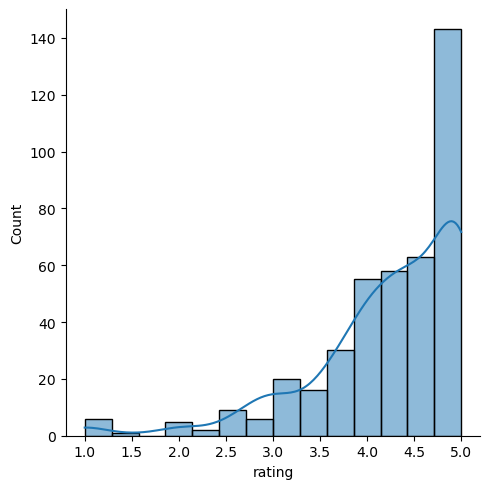

In [387]:
#Exclude 0 ratings as it means there are no current ratings for that product
sns.displot(data=df[df["rating"] != 0], x="rating", kde=True)

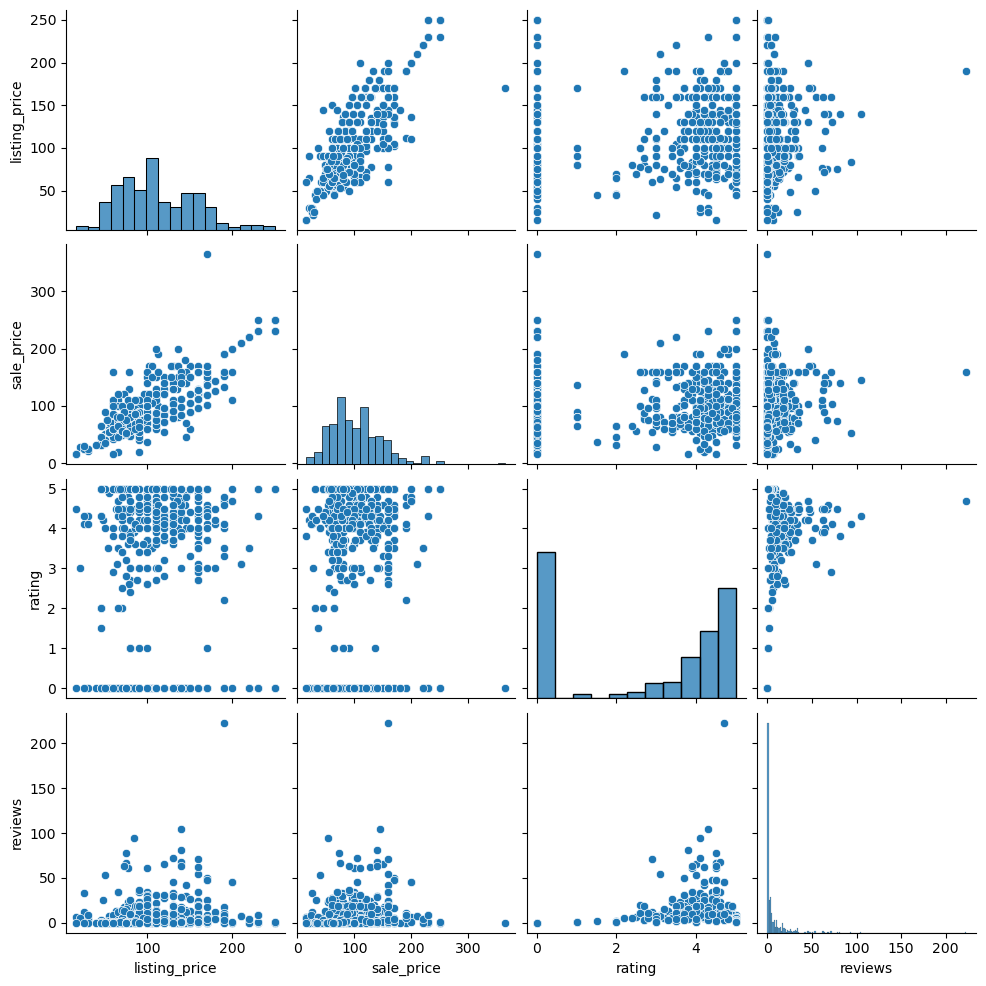

In [388]:
sns.pairplot(df)

In [389]:
df['price_difference'] = df['listing_price'] - df['sale_price']

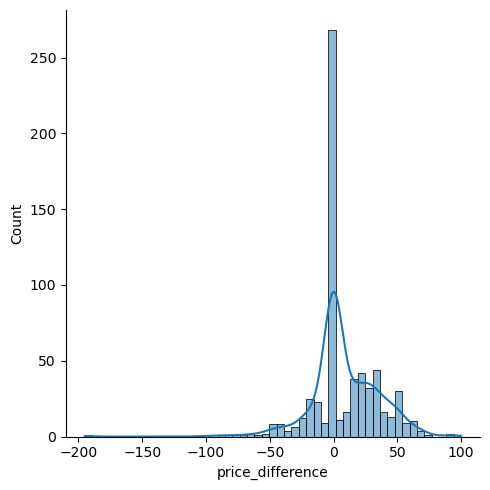

In [390]:
'''
If we consider listing_price as the original or recommended retail price of the product and 
sale_price as the price at which it's actually being sold: then

Listing Price > Sale Price indicates
product is being sold at a discount i.e. clear out old inventory, compute with other sellers

Listing Price < Sale Price indicates
if demand is high, prices might surge above the original listing price.
could be part of collector's item
dynamic pricing
'''
sns.displot(data=df, x="price_difference", kde=True)

In [391]:
df['price_ratio'] = df['sale_price'] / df['listing_price']

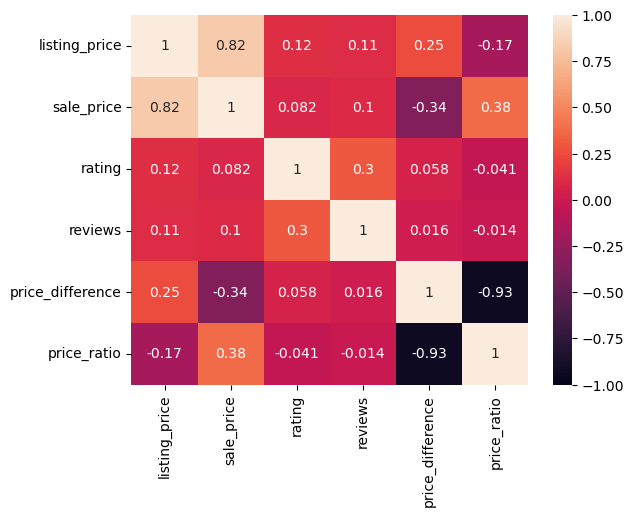

In [392]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);

In [393]:
#  price_ratio
df['price_ratio'] = df['sale_price'] / df['listing_price']

# price_category
# You can adjust the quantiles as needed
quantiles = df['sale_price'].quantile([0.33, 0.66]).values
df['price_category'] = pd.cut(df['sale_price'], 
                              bins=[0] + list(quantiles) + [float('inf')], 
                              labels=['low', 'medium', 'high'])

df[['price_ratio', 'price_category']].head()

,price_ratio,price_category
0,1.339110,low
1,1.000000,low
2,1.111173,medium
3,1.666667,medium
4,1.000000,medium


In [394]:
df.head(5)

,product_name,product_id,listing_price,sale_price,brand,description,rating,reviews,price_difference,price_ratio,price_category
0,Nike Air Force 1 '07 Essential,CJ1646-600,55.97,74.95,Nike,Let your shoe game shimmer in the Nike Air For...,0.0,0,-18.98,1.339110,low
1,Nike Air Force 1 '07,CT4328-101,74.95,74.95,Nike,The legend lives on in the Nike Air Force 1 '0...,0.0,0,0.00,1.000000,low
2,Nike Air Force 1 Sage Low LX,CI3482-200,89.95,99.95,Nike,"Taking both height and craft to new levels, th...",0.0,0,-10.00,1.111173,medium
3,Nike Air Max Dia SE,CD0479-200,59.97,99.95,Nike,"Designed for a woman's foot, the Nike Air Max ...",0.0,0,-39.98,1.666667,medium
4,Nike Air Max Verona,CZ6156-101,99.95,99.95,Nike,Pass on the good vibes in the Nike Air Max Ver...,0.0,0,0.00,1.000000,medium


In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   product_name      643 non-null    object  
 1   product_id        643 non-null    object  
 2   listing_price     643 non-null    float64 
 3   sale_price        643 non-null    float64 
 4   brand             643 non-null    object  
 5   description       643 non-null    object  
 6   rating            643 non-null    float64 
 7   reviews           643 non-null    int64   
 8   price_difference  643 non-null    float64 
 9   price_ratio       643 non-null    float64 
 10  price_category    643 non-null    category
dtypes: category(1), float64(5), int64(1), object(4)
memory usage: 51.1+ KB


In [396]:
label_encoder = LabelEncoder()
# Convert 'price_category' to numeric using label encoding
df['price_category_encoded'] = label_encoder.fit_transform(df['price_category'])
# Standardizing the data
features = ['listing_price', 'sale_price', 'rating', 'reviews', 'price_difference', 'price_ratio', 'price_category_encoded']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])
# Hierarchical Clustering
linked = linkage(scaled_data, 'ward')

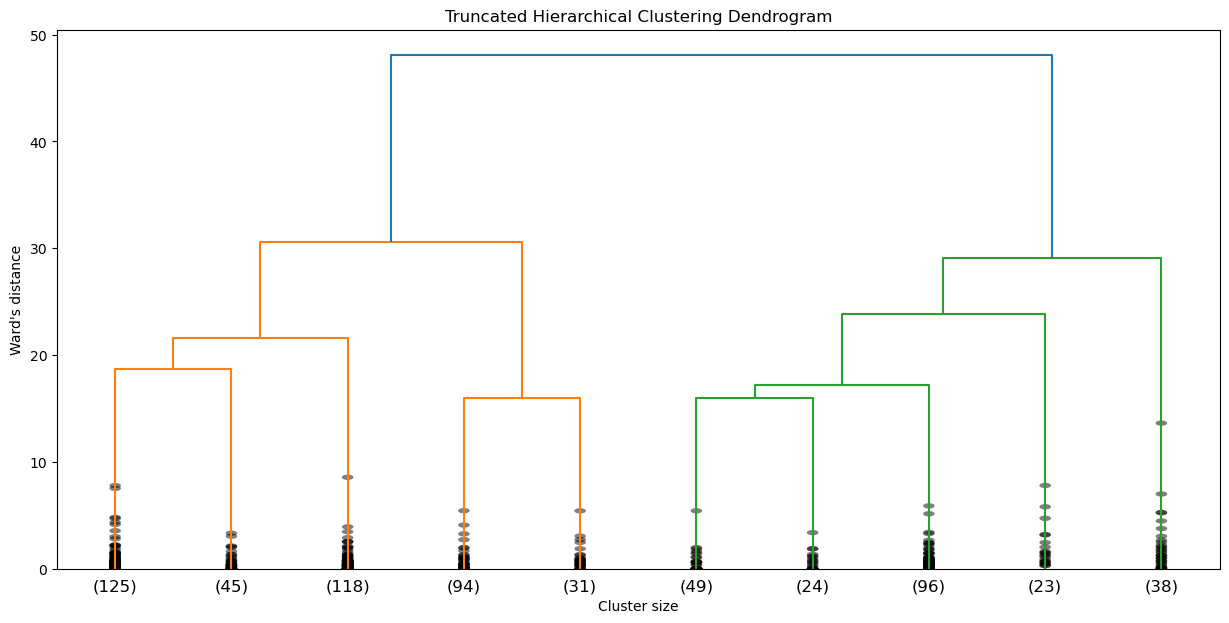

In [397]:
# Visualization: Dendrogram with Truncation
plt.figure(figsize=(15, 7))
dendrogram(linked,
           truncate_mode='lastp',  # Show only the last 'p' merged clusters
           p=10,  # Show only the last 10 merged clusters
           show_contracted=True,  # To give a summarized view
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title("Truncated Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster size")
plt.ylabel("Ward's distance")
plt.show()

In [398]:
scaled_df = pd.DataFrame(scaled_data, columns=features)
for col in df.columns:
    if col not in features:
        scaled_df[col] = df[col]

In [399]:
scaled_df

,listing_price,sale_price,rating,reviews,price_difference,price_ratio,price_category_encoded,product_name,product_id,brand,description,price_category
0,-1.250013,-0.602840,-1.280299,-0.450113,-1.037481,1.567450,-0.028505,Nike Air Force 1 '07 Essential,CJ1646-600,Nike,Let your shoe game shimmer in the Nike Air For...,low
1,-0.816728,-0.602840,-1.280299,-0.450113,-0.323246,0.235658,-0.028505,Nike Air Force 1 '07,CT4328-101,Nike,The legend lives on in the Nike Air Force 1 '0...,low
2,-0.474300,-0.048489,-1.280299,-0.450113,-0.699555,0.672268,1.193416,Nike Air Force 1 Sage Low LX,CI3482-200,Nike,"Taking both height and craft to new levels, th...",medium
3,-1.158699,-0.048489,-1.280299,-0.450113,-1.827730,2.853867,1.193416,Nike Air Max Dia SE,CD0479-200,Nike,"Designed for a woman's foot, the Nike Air Max ...",medium
4,-0.246015,-0.048489,-1.280299,-0.450113,-0.323246,0.235658,1.193416,Nike Air Max Verona,CZ6156-101,Nike,Pass on the good vibes in the Nike Air Max Ver...,medium
...,...,...,...,...,...,...,...,...,...,...,...,...
638,1.123695,0.572827,1.060424,-0.387441,0.880191,-0.549560,-1.250426,Air Jordan 8 Retro,CI1236-100,Nike,The Air Jordan 8 Retro recaptures the memorabl...,high
639,-1.387441,-1.489358,-1.280299,-0.450113,0.240465,-0.942143,-0.028505,Nike Phantom Venom Club IC,AO0578-717,Nike,The Nike Phantom Venom Club IC is engineered f...,low
640,-0.588443,-0.946094,1.060424,-0.387441,0.635590,-0.942305,-0.028505,Nike Mercurial Superfly 7 Academy TF,AT7978-414,Nike,The soft upper of the Nike Mercurial Superfly ...,low
641,1.351980,1.503693,0.592279,-0.199422,-0.323246,0.235658,-1.250426,Nike Air Max 98,AH6799-300,Nike,The Nike Air Max 98 features the OG design lin...,high


In [400]:
# Assuming you want the number of clusters to be determined from the dendrogram (for example, let's say 6 clusters at Ward's distance 20)
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
df['cluster_labels'] = cluster.fit_predict(scaled_df[features])

In [401]:
df[df["cluster_labels"] == 1]

,product_name,product_id,listing_price,sale_price,brand,description,rating,reviews,price_difference,price_ratio,price_category,price_category_encoded,cluster_labels
8,Nike Zoom Pegasus Turbo 2,AT8242-009,159.95,159.95,Nike,The Nike Zoom Pegasus Turbo 2 is updated with ...,2.7,14,0.00,1.000000,high,0,1
9,Nike Air Max 270 React ENG,CK2595-500,149.95,149.95,Nike,The Nike Air Max 270 React ENG combines a full...,5.0,2,0.00,1.000000,high,0,1
16,Nike Air Max 270 React ENG,CK2608-100,149.95,149.95,Nike,Refresh your step in the Nike Air Max 270 Reac...,0.0,0,0.00,1.000000,high,0,1
17,Nike Air Max 97,921733-104,159.95,169.95,Nike,The Nike Air Max 97 keeps a sneaker icon going...,4.3,16,-10.00,1.062520,high,0,1
20,Nike Air Max 97,CT4525-001,169.95,159.95,Nike,Remastered from the OG that shook up the runni...,0.0,0,10.00,0.941159,high,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,Nike Metcon 5 AMP,CN5455-160,119.95,119.95,Nike,The Nike Metcon 5 AMP arms you with stability ...,4.5,2,0.00,1.000000,high,0,1
632,Air Jordan 5 Retro,CD2722-001,189.95,159.95,Nike,The Air Jordan 5 Retro for women gives a colou...,3.3,3,30.00,0.842064,high,0,1
637,Nike React Metcon AMP,CT9155-063,139.95,139.95,Nike,The Nike React Metcon AMP takes the stability ...,3.0,1,0.00,1.000000,high,0,1
638,Air Jordan 8 Retro,CI1236-100,159.95,127.97,Nike,The Air Jordan 8 Retro recaptures the memorabl...,5.0,1,31.98,0.800063,high,0,1


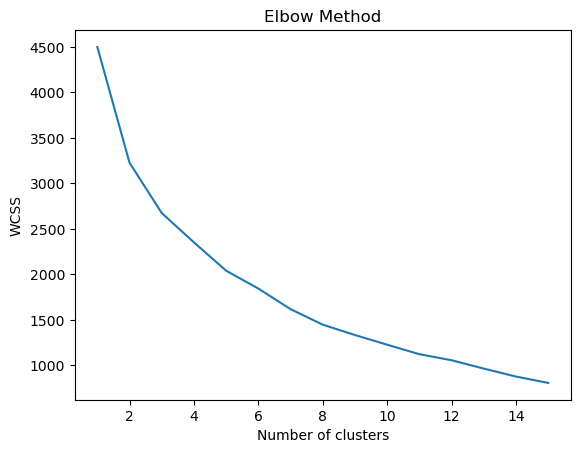

In [402]:
from sklearn.cluster import KMeans

# Using the Elbow method to find the optimal number of clusters
wcss = []  # within-cluster sum of squares
for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
    
# Plot the Elbow method
plt.plot(range(1, 16), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [403]:
# Apply KMeans clustering
optimal_clusters = 10  # replace this with the optimal number you observed
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
df['kmeans_cluster_labels'] = kmeans.fit_predict(scaled_data)

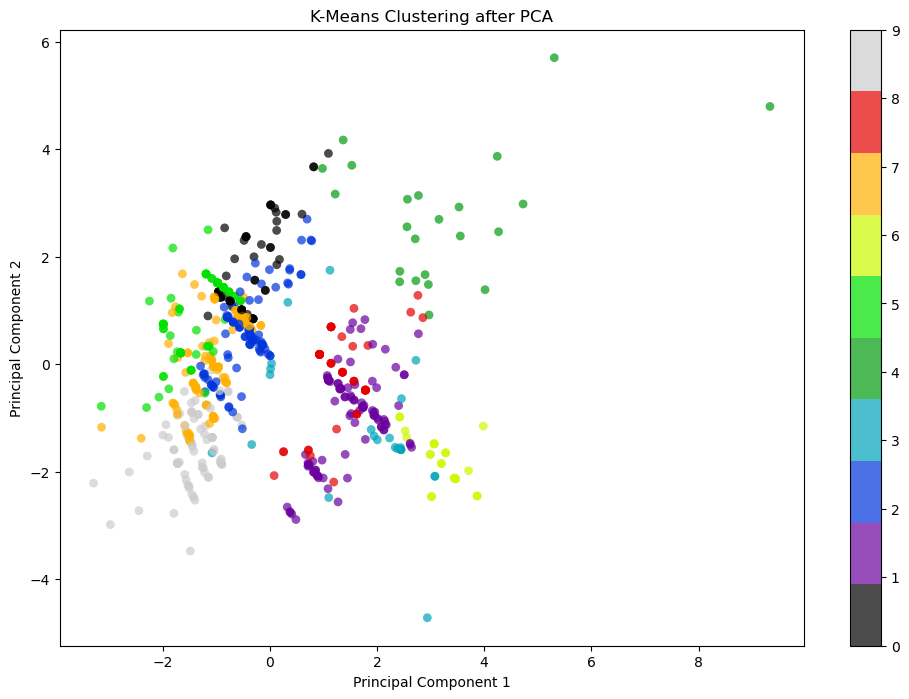

In [404]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_data)

plt.figure(figsize=(12, 8))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=df['kmeans_cluster_labels'], edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('K-Means Clustering after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()